#### 檔案產出：efficientnet.h5檔案(會在models資料夾下面)，即訓練完成的efficientnet模型
#### 主要做的事情：oversampling、data augmentation、model、hyperparameter tuning

In [1]:
# 載入所需套件
%matplotlib inline
import os
import glob
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import cv2
import torchvision
import copy
import time
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils import data
from torchvision import transforms
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# 不要用科學記號
np.set_printoptions(suppress=True)

In [2]:
# 看 batch1_images_cut_formal 各類別張數比例
# glob可以找某種類型檔案的路徑，不指定檔名就是全部
dataset = ['train', 'valid', 'test']
patterns = ["abstract", "animal print", "camouflage", "floral", "geometric", "ikat",
            "melange", "placement", "plaids", "solid", "spots", "strips"]
train_info_df = pd.DataFrame()
train_info_df['patterns'] = patterns
train_info_df = train_info_df.set_index('patterns')
train_info_df['numbers'] = 0
train_info_df['ratio (%)'] = 0

print("查看 train、valid、test 資料分布(切分有按照 per class 切分):")
for d in dataset:
    dataset_len = 0
    category_len = []
    for i in range(len(patterns)):
        basepath = os.path.join("./batch1_images_cut_formal/{}".format(d), patterns[i], "*")  # *.jpg代表抓所有jpg檔案，*就是所有檔案
        cand_fn = glob.glob(basepath)
        dataset_len += len(cand_fn)
        category_len.append(len(cand_fn))
    print("{} has {} pictures.".format(d, dataset_len))
    for j in range(len(category_len)):
        print("\t {}: {} 張 ({:.2%})".format(patterns[j], category_len[j], category_len[j]/dataset_len))
        if d == 'train':
            train_info_df.loc[patterns[j], 'numbers'] = category_len[j]
            train_info_df.loc[patterns[j], 'ratio (%)'] = round(category_len[j]/dataset_len, 4) * 100
    print()

print("train valid test 切分比例:")
total_len = 0
dataset_len_list = []
for d in dataset:
    dataset_len = 0
    for i in range(len(patterns)):
        basepath = os.path.join("./batch1_images_cut_formal/{}".format(d), patterns[i], "*")  # *.jpg代表抓所有jpg檔案，*就是所有檔案
        cand_fn = glob.glob(basepath)
        dataset_len += len(cand_fn)
    dataset_len_list.append(dataset_len)
    total_len += dataset_len
for i in range(3):
    print("{} set：{:.2%}".format(dataset[i], dataset_len_list[i]/total_len))
print()

print("訓練集中各 pattern 分布:")
train_info_df  

查看 train、valid、test 資料分布(切分有按照 per class 切分):
train has 6200 pictures.
	 abstract: 726 張 (11.71%)
	 animal print: 115 張 (1.85%)
	 camouflage: 306 張 (4.94%)
	 floral: 305 張 (4.92%)
	 geometric: 445 張 (7.18%)
	 ikat: 10 張 (0.16%)
	 melange: 1585 張 (25.56%)
	 placement: 281 張 (4.53%)
	 plaids: 211 張 (3.40%)
	 solid: 1767 張 (28.50%)
	 spots: 22 張 (0.35%)
	 strips: 427 張 (6.89%)

valid has 2068 pictures.
	 abstract: 242 張 (11.70%)
	 animal print: 38 張 (1.84%)
	 camouflage: 102 張 (4.93%)
	 floral: 102 張 (4.93%)
	 geometric: 148 張 (7.16%)
	 ikat: 4 張 (0.19%)
	 melange: 528 張 (25.53%)
	 placement: 94 張 (4.55%)
	 plaids: 71 張 (3.43%)
	 solid: 589 張 (28.48%)
	 spots: 8 張 (0.39%)
	 strips: 142 張 (6.87%)

test has 2074 pictures.
	 abstract: 243 張 (11.72%)
	 animal print: 39 張 (1.88%)
	 camouflage: 102 張 (4.92%)
	 floral: 102 張 (4.92%)
	 geometric: 149 張 (7.18%)
	 ikat: 4 張 (0.19%)
	 melange: 529 張 (25.51%)
	 placement: 94 張 (4.53%)
	 plaids: 71 張 (3.42%)
	 solid: 590 張 (28.45%)
	 spots: 8 張 (0.39%

numbers  ratio (%)
patterns                        
abstract          726      11.71
animal print      115       1.85
camouflage        306       4.94
floral            305       4.92
geometric         445       7.18
ikat               10       0.16
melange          1585      25.56
placement         281       4.53
plaids            211       3.40
solid            1767      28.50
spots              22       0.35
strips            427       6.89

In [3]:
label2index = {
    "abstract": 0,
    "animal print": 1,
    "camouflage": 2,
    "floral": 3,
    "geometric": 4,
    "ikat": 5,
    "melange": 6,
    "placement": 7,
    "plaids": 8,
    "solid": 9,
    "spots": 10,
    "strips": 11,
}

index2label = {
    0: "abstract",
    1: "animal print",
    2: "camouflage",
    3: "floral",
    4: "geometric",
    5: "ikat",
    6: "melange",
    7: "placement",
    8: "plaids",
    9: "solid",
    10: "spots",
    11: "strips",
}

train abstract
train animal print
train camouflage
train floral
train geometric
train ikat
train melange
train placement
train plaids
train solid
train spots
train strips

valid abstract
valid animal print
valid camouflage
valid floral
valid geometric
valid ikat
valid melange
valid placement
valid plaids
valid solid
valid spots
valid strips

test abstract
test animal print
test camouflage
test floral
test geometric
test ikat
test melange
test placement
test plaids
test solid
test spots
test strips

train length 6200
valid length 2068
test length 2074

(256, 256, 3)


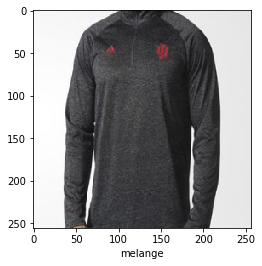

(256, 256, 3)


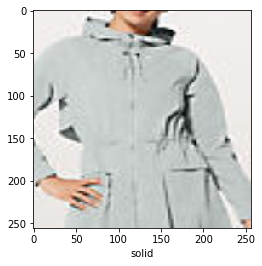

(256, 256, 3)


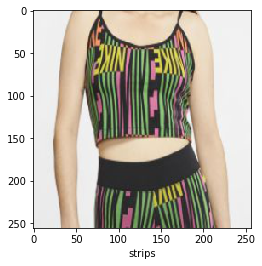

In [4]:
# 讀 batch1_images_cut_formal 資料
x_train_list = []
x_valid_list = []
x_test_list = []

y_train_list = []
y_valid_list = []
y_test_list = []


for d in dataset:
    for p in patterns:
        basepath = os.path.join("batch1_images_cut_formal/{}/{}".format(d, p), "*")  # *.jpg代表抓所有jpg檔案，*就是所有檔案
        pictures_list = glob.glob(basepath)
        print(d, p)  # log
        for pic in pictures_list:
            img = Image.open(pic)
            img_ = np.array(img)
            
            # 前處理
            if d == 'train':
                x_train_list.append(img_)
                y_train_list.append(label2index[p])

            elif d == 'valid':
                x_valid_list.append(img_)
                y_valid_list.append(label2index[p])

            elif d == 'test':
                x_test_list.append(img_)
                y_test_list.append(label2index[p])
            
            img.close() # 關掉圖片，避免too many open files error
    print()

                    
# 印出來看看有沒有前處理成功
random_index1 = random.randint(0, len(x_train_list)-1)
random_index2 = random.randint(0, len(x_valid_list)-1)
random_index3 = random.randint(0, len(x_test_list)-1)

print("train length", len(x_train_list))
print("valid length", len(x_valid_list)) 
print("test length", len(x_test_list)) 
print()

print(x_train_list[random_index1].shape) 
plt.imshow(x_train_list[random_index1])
plt.xlabel(index2label[y_train_list[random_index1]])
plt.show()

print(x_valid_list[random_index2].shape)            
plt.imshow(x_valid_list[random_index2])
plt.xlabel(index2label[y_valid_list[random_index2]])
plt.show()

print(x_test_list[random_index3].shape)            
plt.imshow(x_test_list[random_index3])
plt.xlabel(index2label[y_test_list[random_index3]])
plt.show()

In [5]:
X_train = np.array(x_train_list)
X_valid = np.array(x_valid_list)
X_test = np.array(x_test_list)

y_train = np.array(y_train_list)
y_valid = np.array(y_valid_list)
y_test = np.array(y_test_list)

In [6]:
# oversampling
repeat_dict = {
#     0: 1,
    1: 3 ,
    2: 1,
    3: 1,
#     4: 9,
    5: 49,
#     6: ,
    7: 1,
    8: 1,
#     9: 9,
    10: 19,
#     11: 3,
}


X_train_copy = copy.deepcopy(X_train)
y_train_copy = copy.deepcopy(y_train)


for i in range(12):
    if i not in repeat_dict.keys():
        print("Pass %s class" % (i))
        pass
    else:
        cur_indexes = np.where(y_train_copy == i)
        repeat_x = np.repeat(X_train_copy[cur_indexes[0]], repeats=repeat_dict[i], axis=0)
        repeat_y = np.repeat(y_train_copy[cur_indexes[0]], repeats=repeat_dict[i], axis=0)
        X_train = np.concatenate((X_train, repeat_x), axis=0)
        y_train = np.concatenate((y_train, repeat_y), axis=0)
        print("Finish %s class" % (i))

Pass 0 class
Finish 1 class
Finish 2 class
Finish 3 class
Pass 4 class
Finish 5 class
Pass 6 class
Finish 7 class
Finish 8 class
Pass 9 class
Finish 10 class
Pass 11 class


In [7]:
print("X trains oversample 之後的總訓練筆數 %s" % (len(X_train),))
print("y trains oversample 之後的總訓練筆數 %s" % (len(y_train),))
for i in range(12):
    count = len(np.where(y_train == i)[0])
    if i not in repeat_dict.keys():
        print("class %2s 原本有 %5s 筆資料， 乘以 %2s 之後，有 %5s 筆資料" % (i, count, 1, count))
    else:
        print("class %2s 原本有 %5s 筆資料， 乘以 %2s 之後，有 %5s 筆資料" % (i, int(count/(repeat_dict[i]+1)), repeat_dict[i]+1, count))

X trains oversample 之後的總訓練筆數 8556
y trains oversample 之後的總訓練筆數 8556
class  0 原本有   726 筆資料， 乘以  1 之後，有   726 筆資料
class  1 原本有   115 筆資料， 乘以  4 之後，有   460 筆資料
class  2 原本有   306 筆資料， 乘以  2 之後，有   612 筆資料
class  3 原本有   305 筆資料， 乘以  2 之後，有   610 筆資料
class  4 原本有   445 筆資料， 乘以  1 之後，有   445 筆資料
class  5 原本有    10 筆資料， 乘以 50 之後，有   500 筆資料
class  6 原本有  1585 筆資料， 乘以  1 之後，有  1585 筆資料
class  7 原本有   281 筆資料， 乘以  2 之後，有   562 筆資料
class  8 原本有   211 筆資料， 乘以  2 之後，有   422 筆資料
class  9 原本有  1767 筆資料， 乘以  1 之後，有  1767 筆資料
class 10 原本有    22 筆資料， 乘以 20 之後，有   440 筆資料
class 11 原本有   427 筆資料， 乘以  1 之後，有   427 筆資料


In [8]:
# data augmentation
datagen = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 隨機水平翻轉(Horizontal Flip)
    transforms.RandomRotation((-40,40)),  # 隨機旋轉-40度到40度
    transforms.ColorJitter(brightness=0.2, contrast=0, saturation=0, hue=0.3), # 0.2 代表[max(0, 1 - brightness), 1 + brightness] = (0.8, 1.2)
                                                                              # 參數分別是 亮度、對比、飽和、色調
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 調整RGB的均數與標準差，暫時照抄HW 實測有沒有做準確率相同
])

datagen_valid_test = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 調整RGB的均數與標準差，暫時照抄HW 實測有沒有做準確率相同
])

X_train_aug = []
X_valid_processed = []
X_test_processed = []

for i in range(len(X_train)):
    cur_img = datagen(Image.fromarray(X_train[i]))
    X_train_aug.append(cur_img)
print("Finish train")
    
for i in range(len(X_valid)):
    cur_img = datagen_valid_test(Image.fromarray(X_valid[i]))
    X_valid_processed.append(cur_img)
print("Finish valid")

for i in range(len(X_test)):
    cur_img = datagen_valid_test(Image.fromarray(X_test[i]))
    X_test_processed.append(cur_img)
print("Finish test")

Finish train
Finish valid
Finish test


原始圖檔:


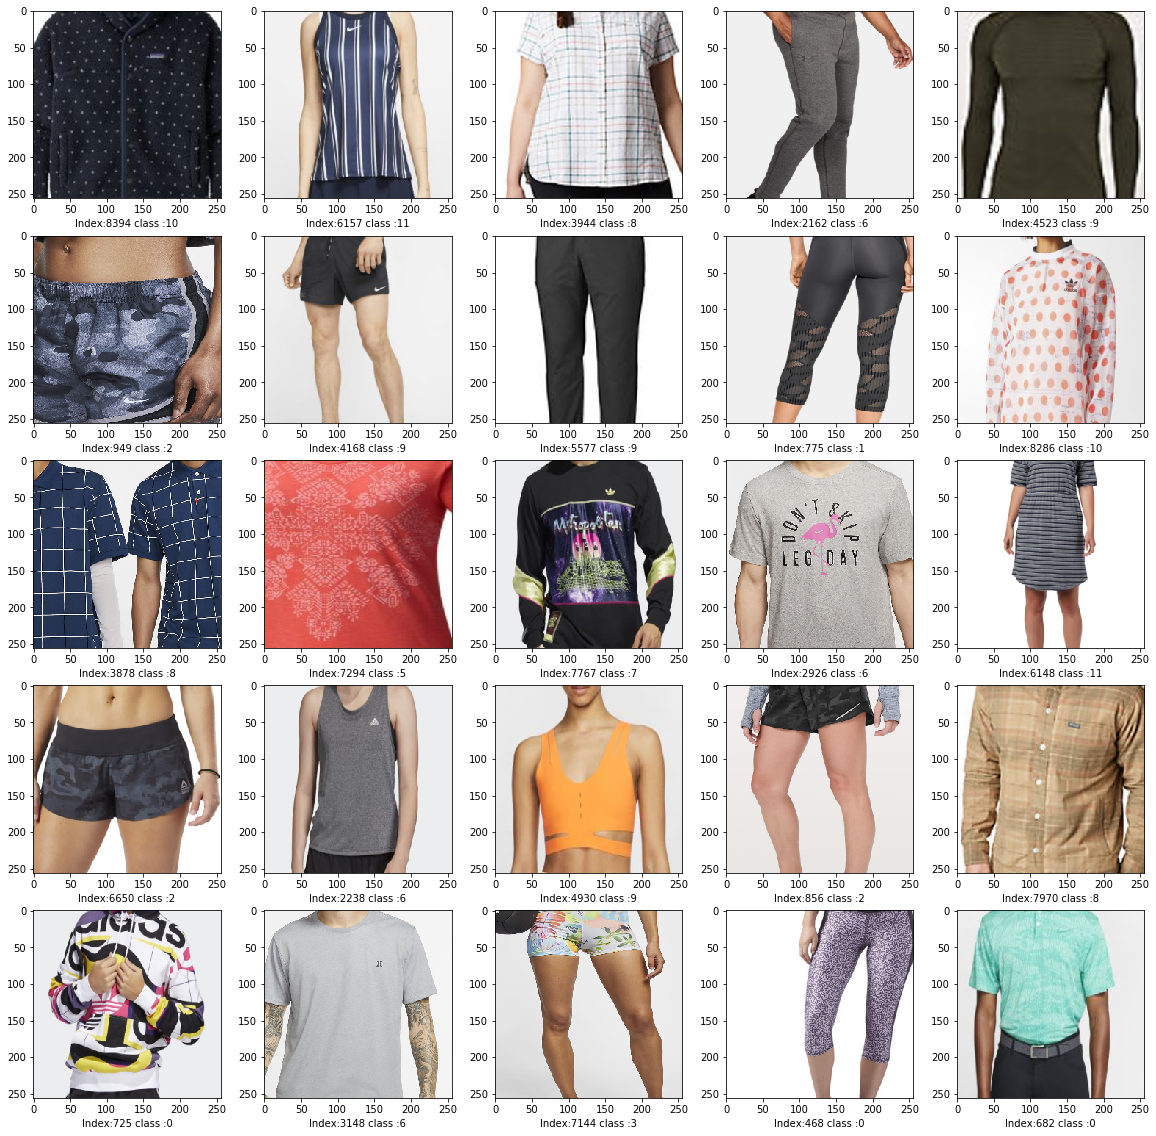

In [9]:
print("原始圖檔:")
randomlist = random.sample(range(0, len(X_train)), 25)
plt.figure(figsize=(20,20))
for i, df_index in enumerate(randomlist):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[df_index])
    plt.xlabel('Index:' + str(df_index) + ' class :' + str(y_train[df_index])) 
plt.show()

轉換後的圖檔:


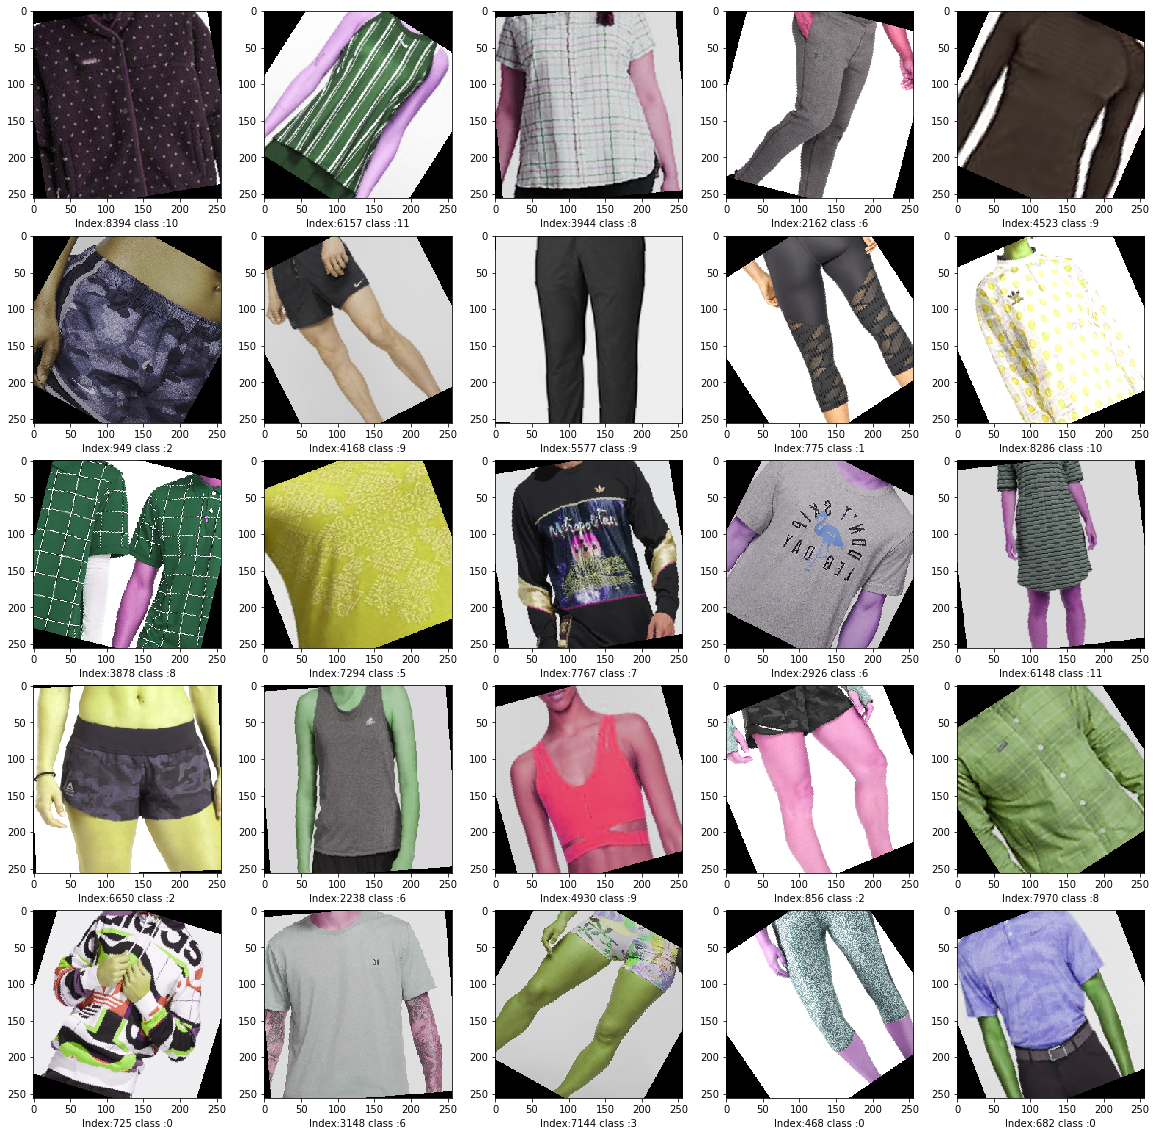

In [10]:
print("轉換後的圖檔:")
# randomlist = random.sample(range(0, len(train_images)), 25)
plt.figure(figsize=(20,20))
for i, df_index in enumerate(randomlist):
    plt.subplot(5,5,i+1)
    test_img = X_train_aug[df_index]
    test_img = test_img.permute(1, 2, 0)
    plt.imshow(test_img)
    plt.xlabel('Index:' + str(df_index) + ' class :' + str(y_train[df_index])) 
plt.show()

In [11]:
# 轉成 pytorch 的規格
X_train = torch.stack(X_train_aug)
X_valid = torch.stack(X_valid_processed)
# X_valid = X_valid.permute(0, 3, 1, 2)
X_test = torch.stack(X_test_processed)
# X_test = X_test.permute(0, 3, 1, 2)

y_train = torch.FloatTensor(y_train)
y_valid = torch.FloatTensor(y_valid)
y_test = torch.FloatTensor(y_test)

print("x_train shape = ", X_train.shape)
print("x_valid shape = ", X_valid.shape)
print("x_test shape = ", X_test.shape)
print()
print("y_train shape = ", y_train.shape)
print("y_valid shape = ", y_valid.shape)
print("y_test shape = ", y_test.shape)

x_train shape =  torch.Size([8556, 3, 256, 256])
x_valid shape =  torch.Size([2068, 3, 256, 256])
x_test shape =  torch.Size([2074, 3, 256, 256])

y_train shape =  torch.Size([8556])
y_valid shape =  torch.Size([2068])
y_test shape =  torch.Size([2074])


In [12]:
# dataset & dataloader
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, Xnp, Ynp):
        'Initialization, passing Xnp and Ynp'
        self.labels = Ynp # 可以不用
        self.nobs = Xnp.shape[0]        
        self.Xnp = Xnp
        self.Ynp = Ynp
    def __len__(self):
        'Denotes the total number of samples'
        return self.nobs
    def __getitem__(self, index):
        'Generates one sample of data'        
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y

minibatch_size = 8
trainset = Dataset(X_train, y_train)
validset = Dataset(X_valid, y_valid)
testset = Dataset(X_test, y_test)

trainloader = data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True, num_workers=0) # window要設0
validloader = data.DataLoader(validset, batch_size=minibatch_size, shuffle=True, num_workers=0) # window要設0
testloader = data.DataLoader(testset, batch_size=minibatch_size, shuffle=False, num_workers=0)

X_batch, y_batch = next(iter(trainloader))
print("X_batch size:", X_batch.size())
print("y_batch size:", y_batch.size())

X_batch size: torch.Size([8, 3, 256, 256])
y_batch size: torch.Size([8])


0 torch.Size([8, 3, 256, 256]) torch.Size([8])


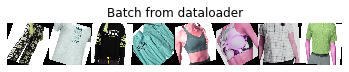

1 torch.Size([8, 3, 256, 256]) torch.Size([8])


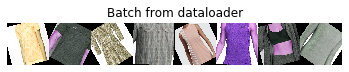

2 torch.Size([8, 3, 256, 256]) torch.Size([8])


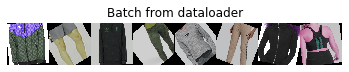

3 torch.Size([8, 3, 256, 256]) torch.Size([8])


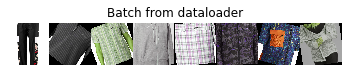

In [13]:
def show_batch(imgs):
    grid = torchvision.utils.make_grid(imgs)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

for i, (X_batch, y_batch) in enumerate(trainloader):
    if(i<4):
        print(i, X_batch.size(),y_batch.size())
        show_batch(X_batch)
        plt.axis('off')
        plt.show()

## 建模

#### random forest (baseline)

In [14]:
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators=200, random_state=89)
# model.fit(X_train.reshape(X_train.shape[0],-1), y_train)
# print("驗證")
# ypred = model.predict(X_valid.reshape(X_valid.shape[0],-1))
# print(metrics.classification_report(y_valid, ypred))

In [15]:
# print("測試")
# ypred_1 = model.predict(X_test.reshape(X_test.shape[0],-1))
# print(metrics.classification_report(y_test, ypred_1))

In [16]:
del X_train
del X_valid
# del X_test
del y_train
del y_valid
# del y_test

### Efficient net

In [17]:
# efficient net

# model = EfficientNet.from_pretrained('efficientnet-b7')

# num_classes = 12
# model._fc.out_features = num_classes
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 等同summary功能，太長先註解
# print(model)

In [18]:
# 模型設定
optimizer_type = "Adam"
LR = 0.001
nepoch = 50
batch_patience = 15
momentum = 0.01
weight_decay = 0
loss_fn = nn.CrossEntropyLoss()
num_class = 12
step_size = 3
is_pretrain=True

In [19]:
def construct_net(LR, momentum=0, weight_decay=0, optimizer_type="SGD", step_size=2, is_pretrain=True):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        device = "cuda"   
    else:
        device = "cpu"
    print("Running on device: ", device)

    # pre-train efficientnet
    if is_pretrain:
        model = EfficientNet.from_pretrained('efficientnet-b1')
#         model = torchvision.models.resnet50(pretrained=True)
    else:
        model = EfficientNet.from_name('efficientnet-b1')   # 就是重新開始訓練  b4b3b2跑不動
#         model = torchvision.models.resnet50(pretrained=False)

    # convert everything to float precision. 
    model = model.float()
    # move the model to device (i.e., cpu or gpu)
    model = model.to(device)

    # 輸出改成12類別
    model._fc.out_features = num_class
#     model.fc.out_features = num_class  # resnet
    
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay = 0)

    scheduler = StepLR(optimizer, step_size, gamma=0.1)  # LR在每 step_size個epoch後就會 * gamma
        
    return model, optimizer, device, scheduler

In [20]:
def model_training(model, optimizer, device, trainloader, validloader, loss_fn, scheduler,
                    nepoch=200, batch_patience=2):
    # 模型計算需要的變數
    step_count = 0               # 計算 batch數
    best_valid_loss = np.inf     # 最佳驗證損失
    best_valid_acc = 0           # 最佳驗證正確率
    is_early_stop = False        # 是否達到 early stop條件
    
    # RMSE list，繪圖用
    training_losses = []         # 紀錄每個epoch的訓練loss
    valid_losses = []            # 紀錄每個epoch的驗證loss
    
    # 最佳結果，測試用
    best_epoch = 0               # 最佳 epoch，現在是一個epoch算一次loss，所以early stopping看這個
    best_model_weights = None    # 最佳模型參數

    for epoch_id in range(0, nepoch):
        for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
            step_count += 1
            
            ### train ###
            # reshape target to two-dimensional array
#             targets = targets.reshape((-1, 1))  # 算CrossEntropyLoss，不用reshape
            model.train()  # 模型轉為訓練模式
            inputs, targets = inputs.to(device), targets.to(device, dtype=torch.int64)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)  # CrossEntropyLoss：outputs:(minibatch,C)；targets：(minibatch)
            loss.backward()
            optimizer.step()  # 更新參數

        ### valid ###
        # 每個 epoch 算一次 valid loss

        # 紀錄 train RMSE，雖然是分批進去，但是算SSE加總後才除完整資料集長度，所以概念上仍算是整份資料集的RMSE
        train_loss = 0
        train_correct = 0
        train_len = 0
        with torch.no_grad():
            for batch_idx, (inputs_, targets_) in enumerate(trainloader):            
                inputs_, targets_ = inputs_.to(device), targets_.to(device, dtype=torch.int64)
#                 targets_ = targets_.reshape((-1, 1))
                outputs_ = model(inputs_)
                loss = loss_fn(outputs_, targets_)
                train_loss += loss.item()
                
                train_outputs = torch.argmax(outputs_, 1)
                train_len += len(targets_)
                for i in range(len(train_outputs)):
                    if train_outputs[i] == targets_[i]:
                        train_correct += 1
            train_acc = train_correct / train_len
        training_losses.append(train_loss)

        # 紀錄 valid RMSE，雖然是分批進去，但是算SSE加總後才除完整資料集長度，所以概念上仍算是整份資料集的RMSE
        model.eval()  # prep model for evaluation，模型轉為評估模式。 因為有 dropout

        valid_loss = 0
        correct = 0
        valid_len = 0
        with torch.no_grad():
            for batch_idx, (valid_inputs, valid_targets) in enumerate(validloader): 
                valid_inputs = valid_inputs.float()  # 因為train有經過資料增強，已是float型態，valid、test也必須轉成float型態
                valid_inputs, valid_targets = valid_inputs.to(device), valid_targets.to(device, dtype=torch.int64)
#                 valid_targets = valid_targets.reshape((-1, 1))
                valid_outputs = model(valid_inputs)
                loss = loss_fn(valid_outputs, valid_targets)
                valid_loss += loss.item()
                
                valid_outputs_1 = torch.argmax(valid_outputs, 1)
                valid_len += len(valid_targets)
                for i in range(len(valid_outputs_1)):
                    if valid_outputs_1[i] == valid_targets[i]:
                        correct += 1
            valid_acc = correct / valid_len
        valid_losses.append(valid_loss)
        
        scheduler.step()  # 更新學習率
        
        # 一個epoch紀錄一次           
        print("Epoch %d: train loss = %.3f ; train acc = %.3f ; valid Loss = %.3f ; valid acc = %.3f" % (epoch_id, train_loss, train_acc, valid_loss, valid_acc))

        # 更新最佳參數、最佳損失、最佳 batch數  看valid_loss
#         if valid_loss < best_valid_loss:
#             file_path = './models/efficientnet.h5'
#             print("loss improved from {} to {}, saving model to {}".format(best_valid_loss, valid_loss, file_path))
#             best_valid_loss = valid_loss
#             best_model_weights = copy.deepcopy(model.state_dict())
#             torch.save(model.state_dict(), file_path)  # Save model to specified path
#             best_epoch = epoch_id
            
        # 更新最佳參數、最佳損失、最佳 batch數   看valid_acc
        if valid_acc > best_valid_acc:
            file_path = './models/efficientnet.h5'
            print("acc improved from {} to {}, saving model to {}".format(best_valid_acc, valid_acc, file_path))
            best_valid_acc = valid_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), file_path)  # Save model to specified path
            best_epoch = epoch_id
        
        # earlystopping
        if epoch_id - best_epoch >= batch_patience:
            is_early_stop = True
            
        if is_early_stop:
            print("Early stop at epoch {}, best epoch is {}".format(epoch_id, best_epoch))
            break
    
    return best_epoch, best_model_weights, training_losses, valid_losses

In [21]:
def model_testing(best_model, best_model_weights, testloader, loss_fn):
    print("Doing model testing...")
#     best_model.load_state_dict(best_model_weights)
    best_model.load_state_dict(torch.load('./models/efficientnet.h5'))
    
    correct = 0 
    test_len = 0
    y_pred_list = []  # Confusion Matrix
    y_true_list = []  # Confusion Matrix
    
    
    correct_per_class_list = [0] * num_class  # Per-class Accuracy
    len_per_class_list = [0] * num_class  # Per-class Accuracy
    with torch.no_grad():
        best_model.eval()  # 讓模型參數真的不會變動
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs = inputs.float()  # 因為train有經過資料增強，已是float型態，valid、test也必須轉成float型態
            inputs, targets = inputs.to(device), targets.to(device, dtype=torch.int64)
#             targets = targets.reshape((-1, 1))
            outputs = best_model(inputs)
            outputs = torch.argmax(outputs, 1)
#             print(outputs)
#             print(max(outputs))
            y_pred_list.extend(outputs.tolist())
            y_true_list.extend(targets.tolist())
#             print(y_pred_list)
#             print(y_true_list)
            
            # Accuracy, Confusion Matrix, 與Per-class Accuracy
            test_len += len(targets)
            for i in range(len(outputs)):
                len_per_class_list[targets[i]] += 1
                if outputs[i] == targets[i]:
                    correct += 1
                    correct_per_class_list[targets[i]] += 1
                    
        # Accuracy
        test_acc = correct / test_len
        print("total test accuracy = ", test_acc)
        print()
        
        # Confusion Matrix
        labels_ls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        labels_name = ["abstract", "animal print", "camouflage", "floral", "geometric", "ikat",
            "melange", "placement", "plaids", "solid", "spots", "strips"]
        
        cm = confusion_matrix(y_true_list, y_pred_list, labels=labels_ls)
        cm_df = pd.DataFrame(cm, columns=labels_name, index=labels_name)
        cm_df = cm_df.add_prefix('pred_')
        cm_df.index = ['actual_' + str(idx) for idx in cm_df.index]
#         print("Confusion Matrix：")
#         print(cm_df)
#         print()
        
        # Per-class Accuracy
#         for j in range(num_class):
#             print("{} accuracy: {}".format(labels_name[j], correct_per_class_list[j] / len_per_class_list[j]))
            
        print(metrics.classification_report(y_true_list, y_pred_list))
        
        return test_acc, y_true_list, y_pred_list, cm_df


In [22]:
import gc
gc.collect()  # 強制記憶體回收，自動釋放記憶體

64846

In [23]:
# # 調參用，暫時取代下面兩格
# # training
# lr_list = [0.00001, 0.0001, 0.001, 0.01]
# batch_size_list = [4, 8, 16, 32]
# batch_patience_list = [2, 5, 10, 15]
# nepoch_list = [5, 20, 30, 50]
# momentum_list = [0, 0.001, 0.01, 0.1]
# weight_decay_list = [0, 0.0001, 0.001, 0.01]

# for tune_param in weight_decay_list:
#     print("weight_decay = {}".format(tune_param))
#     st = time.time()
#     model, optimizer, device, scheduler = construct_net(LR, momentum, tune_param, optimizer_type, step_size, is_pretrain)

#     best_epoch, best_model_weights, training_losses, valid_losses  = model_training(model, optimizer, device, trainloader, validloader, loss_fn, scheduler,
#                                                      nepoch, batch_patience)
#     ed = time.time()
#     print("training costs {} secs".format(ed-st))
#     print()

#     # testing
#     best_model, optimizer, device, scheduler = construct_net(LR, momentum, tune_param, optimizer_type, step_size)
#     for param in best_model.parameters():
#         param.requires_grad = False
#     test_acc, y_test, y_pred, cm_df = model_testing(best_model, best_model_weights, testloader, loss_fn)
#     print()

In [24]:
# training
st = time.time()
model, optimizer, device, scheduler = construct_net(0.001, momentum, weight_decay, optimizer_type, step_size, is_pretrain)

best_epoch, best_model_weights, training_losses, valid_losses  = model_training(model, optimizer, device, trainloader, validloader, loss_fn, scheduler,
                                                 nepoch, batch_patience)
ed = time.time()
print("costs {} secs".format(ed-st))

Running on device:  cuda
Loaded pretrained weights for efficientnet-b1


  0%|          | 0/1070 [00:00<?, ?it/s]

Epoch 0: train loss = 1126.984 ; train acc = 0.662 ; valid Loss = 293.638 ; valid acc = 0.668
acc improved from 0 to 0.6682785299806576, saving model to ./models/efficientnet.h5


  0%|          | 0/1070 [00:00<?, ?it/s]

Epoch 1: train loss = 925.603 ; train acc = 0.722 ; valid Loss = 256.981 ; valid acc = 0.706
acc improved from 0.6682785299806576 to 0.7059961315280464, saving model to ./models/efficientnet.h5


  0%|          | 2/1070 [00:00<01:34, 11.29it/s]

Epoch 2: train loss = 793.594 ; train acc = 0.757 ; valid Loss = 288.069 ; valid acc = 0.688


  0%|          | 0/1070 [00:00<?, ?it/s]

Epoch 3: train loss = 422.941 ; train acc = 0.872 ; valid Loss = 218.295 ; valid acc = 0.765
acc improved from 0.7059961315280464 to 0.7649903288201161, saving model to ./models/efficientnet.h5


  0%|          | 2/1070 [00:00<01:34, 11.32it/s]

Epoch 4: train loss = 295.117 ; train acc = 0.910 ; valid Loss = 224.659 ; valid acc = 0.757


  0%|          | 2/1070 [00:00<01:34, 11.35it/s]

Epoch 5: train loss = 215.814 ; train acc = 0.938 ; valid Loss = 220.307 ; valid acc = 0.763


  0%|          | 2/1070 [00:00<01:34, 11.35it/s]

Epoch 6: train loss = 177.331 ; train acc = 0.950 ; valid Loss = 229.236 ; valid acc = 0.759


  0%|          | 2/1070 [00:00<01:34, 11.35it/s]

Epoch 7: train loss = 171.695 ; train acc = 0.953 ; valid Loss = 234.345 ; valid acc = 0.759


  0%|          | 2/1070 [00:00<01:34, 11.36it/s]

Epoch 8: train loss = 158.638 ; train acc = 0.955 ; valid Loss = 237.309 ; valid acc = 0.763


  0%|          | 0/1070 [00:00<?, ?it/s]

Epoch 9: train loss = 161.987 ; train acc = 0.955 ; valid Loss = 238.813 ; valid acc = 0.765
acc improved from 0.7649903288201161 to 0.7654738878143134, saving model to ./models/efficientnet.h5


  0%|          | 2/1070 [00:00<01:34, 11.35it/s]

Epoch 10: train loss = 153.811 ; train acc = 0.956 ; valid Loss = 238.889 ; valid acc = 0.765


  0%|          | 2/1070 [00:00<01:34, 11.31it/s]

Epoch 11: train loss = 154.492 ; train acc = 0.954 ; valid Loss = 238.062 ; valid acc = 0.764


  0%|          | 2/1070 [00:00<01:34, 11.32it/s]

Epoch 12: train loss = 164.662 ; train acc = 0.954 ; valid Loss = 239.629 ; valid acc = 0.765


  0%|          | 2/1070 [00:00<01:34, 11.34it/s]

Epoch 13: train loss = 159.363 ; train acc = 0.956 ; valid Loss = 239.547 ; valid acc = 0.762


  0%|          | 2/1070 [00:00<01:34, 11.36it/s]

Epoch 14: train loss = 154.840 ; train acc = 0.956 ; valid Loss = 239.760 ; valid acc = 0.765


  0%|          | 2/1070 [00:00<01:34, 11.33it/s]

Epoch 15: train loss = 159.505 ; train acc = 0.954 ; valid Loss = 240.997 ; valid acc = 0.765


  0%|          | 2/1070 [00:00<01:34, 11.30it/s]

Epoch 16: train loss = 156.307 ; train acc = 0.955 ; valid Loss = 238.391 ; valid acc = 0.764


  0%|          | 0/1070 [00:00<?, ?it/s]

Epoch 17: train loss = 158.249 ; train acc = 0.955 ; valid Loss = 239.967 ; valid acc = 0.766
acc improved from 0.7654738878143134 to 0.7659574468085106, saving model to ./models/efficientnet.h5


  0%|          | 2/1070 [00:00<01:34, 11.35it/s]

Epoch 18: train loss = 158.648 ; train acc = 0.953 ; valid Loss = 239.421 ; valid acc = 0.762


  0%|          | 2/1070 [00:00<01:34, 11.33it/s]

Epoch 19: train loss = 155.685 ; train acc = 0.956 ; valid Loss = 240.330 ; valid acc = 0.762


  0%|          | 2/1070 [00:00<01:34, 11.33it/s]

Epoch 20: train loss = 152.493 ; train acc = 0.959 ; valid Loss = 240.285 ; valid acc = 0.764


  0%|          | 0/1070 [00:00<?, ?it/s]

Epoch 21: train loss = 153.815 ; train acc = 0.956 ; valid Loss = 237.766 ; valid acc = 0.768
acc improved from 0.7659574468085106 to 0.7678916827852998, saving model to ./models/efficientnet.h5


  0%|          | 2/1070 [00:00<01:34, 11.31it/s]

Epoch 22: train loss = 153.484 ; train acc = 0.956 ; valid Loss = 239.646 ; valid acc = 0.763


  0%|          | 2/1070 [00:00<01:33, 11.36it/s]

Epoch 23: train loss = 159.765 ; train acc = 0.954 ; valid Loss = 238.546 ; valid acc = 0.764


  0%|          | 2/1070 [00:00<01:34, 11.36it/s]

Epoch 24: train loss = 158.795 ; train acc = 0.954 ; valid Loss = 238.100 ; valid acc = 0.765


  0%|          | 2/1070 [00:00<01:33, 11.37it/s]

Epoch 25: train loss = 155.600 ; train acc = 0.955 ; valid Loss = 238.125 ; valid acc = 0.766


  0%|          | 2/1070 [00:00<01:34, 11.35it/s]

Epoch 26: train loss = 162.796 ; train acc = 0.953 ; valid Loss = 238.101 ; valid acc = 0.765


  0%|          | 2/1070 [00:00<01:34, 11.34it/s]

Epoch 27: train loss = 162.703 ; train acc = 0.955 ; valid Loss = 241.031 ; valid acc = 0.765


  0%|          | 2/1070 [00:00<01:34, 11.31it/s]

Epoch 28: train loss = 167.032 ; train acc = 0.954 ; valid Loss = 239.130 ; valid acc = 0.765


  0%|          | 2/1070 [00:00<01:34, 11.33it/s]

Epoch 29: train loss = 157.341 ; train acc = 0.958 ; valid Loss = 238.522 ; valid acc = 0.763


  0%|          | 2/1070 [00:00<01:34, 11.33it/s]

Epoch 30: train loss = 158.703 ; train acc = 0.954 ; valid Loss = 239.881 ; valid acc = 0.765


  0%|          | 2/1070 [00:00<01:34, 11.35it/s]

Epoch 31: train loss = 151.257 ; train acc = 0.960 ; valid Loss = 239.844 ; valid acc = 0.763


  0%|          | 2/1070 [00:00<01:34, 11.33it/s]

Epoch 32: train loss = 158.961 ; train acc = 0.955 ; valid Loss = 238.755 ; valid acc = 0.764


  0%|          | 2/1070 [00:00<01:34, 11.34it/s]

Epoch 33: train loss = 157.577 ; train acc = 0.956 ; valid Loss = 239.820 ; valid acc = 0.763


  0%|          | 2/1070 [00:00<01:34, 11.31it/s]

Epoch 34: train loss = 155.164 ; train acc = 0.958 ; valid Loss = 239.692 ; valid acc = 0.765


  0%|          | 2/1070 [00:00<01:34, 11.31it/s]

Epoch 35: train loss = 160.644 ; train acc = 0.952 ; valid Loss = 238.703 ; valid acc = 0.763


100%|██████████| 1070/1070 [01:34<00:00, 11.32it/s]


Epoch 36: train loss = 159.099 ; train acc = 0.955 ; valid Loss = 239.769 ; valid acc = 0.765
Early stop at epoch 36, best epoch is 21
costs 4684.00788974762 secs


In [71]:
# testing
best_model, optimizer, device, scheduler = construct_net(LR, momentum, weight_decay, optimizer_type, step_size)
for param in best_model.parameters():
    param.requires_grad = False
#     print(param.requires_grad)
test_acc, y_test_, y_pred, cm_df = model_testing(best_model, best_model_weights, testloader, loss_fn)
# print(metrics.classification_report(y_test, y_pred))

Running on device:  cuda
Loaded pretrained weights for efficientnet-b1
Doing model testing...
total test accuracy =  0.7569913211186113

              precision    recall  f1-score   support

           0       0.76      0.58      0.66       243
           1       0.51      0.69      0.59        39
           2       0.75      0.75      0.75       102
           3       0.64      0.81      0.72       102
           4       0.47      0.45      0.46       149
           5       0.33      0.25      0.29         4
           6       0.87      0.89      0.88       529
           7       0.58      0.65      0.61        94
           8       0.80      0.99      0.88        71
           9       0.85      0.77      0.81       590
          10       0.33      0.88      0.48         8
          11       0.65      0.76      0.70       143

    accuracy                           0.76      2074
   macro avg       0.63      0.71      0.65      2074
weighted avg       0.77      0.76      0.76      20

In [63]:
max(y_pred)

11

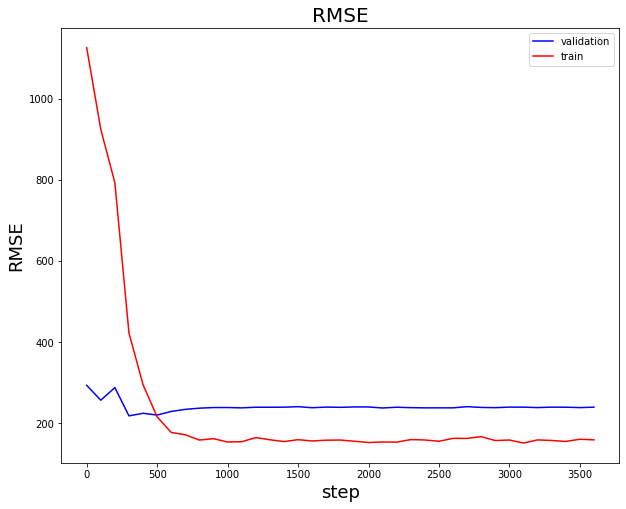

In [27]:
# train valid loss plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
ax.plot([i*100 for i in range(len(valid_losses))], valid_losses, color="blue")
ax.plot([i*100 for i in range(len(training_losses))], training_losses, color="red")
ax.set_title('RMSE', fontsize=20)
plt.xlabel("step", fontsize=18)
plt.ylabel("RMSE", fontsize=18)
plt.legend(['validation', 'train'], loc='best') 
plt.show()

#### 分錯 & 分正確的圖

In [ ]:
# y_test = y_test.tolist()
# for i in range(len(y_test)):
#     y_test[i] = int(y_test[i])

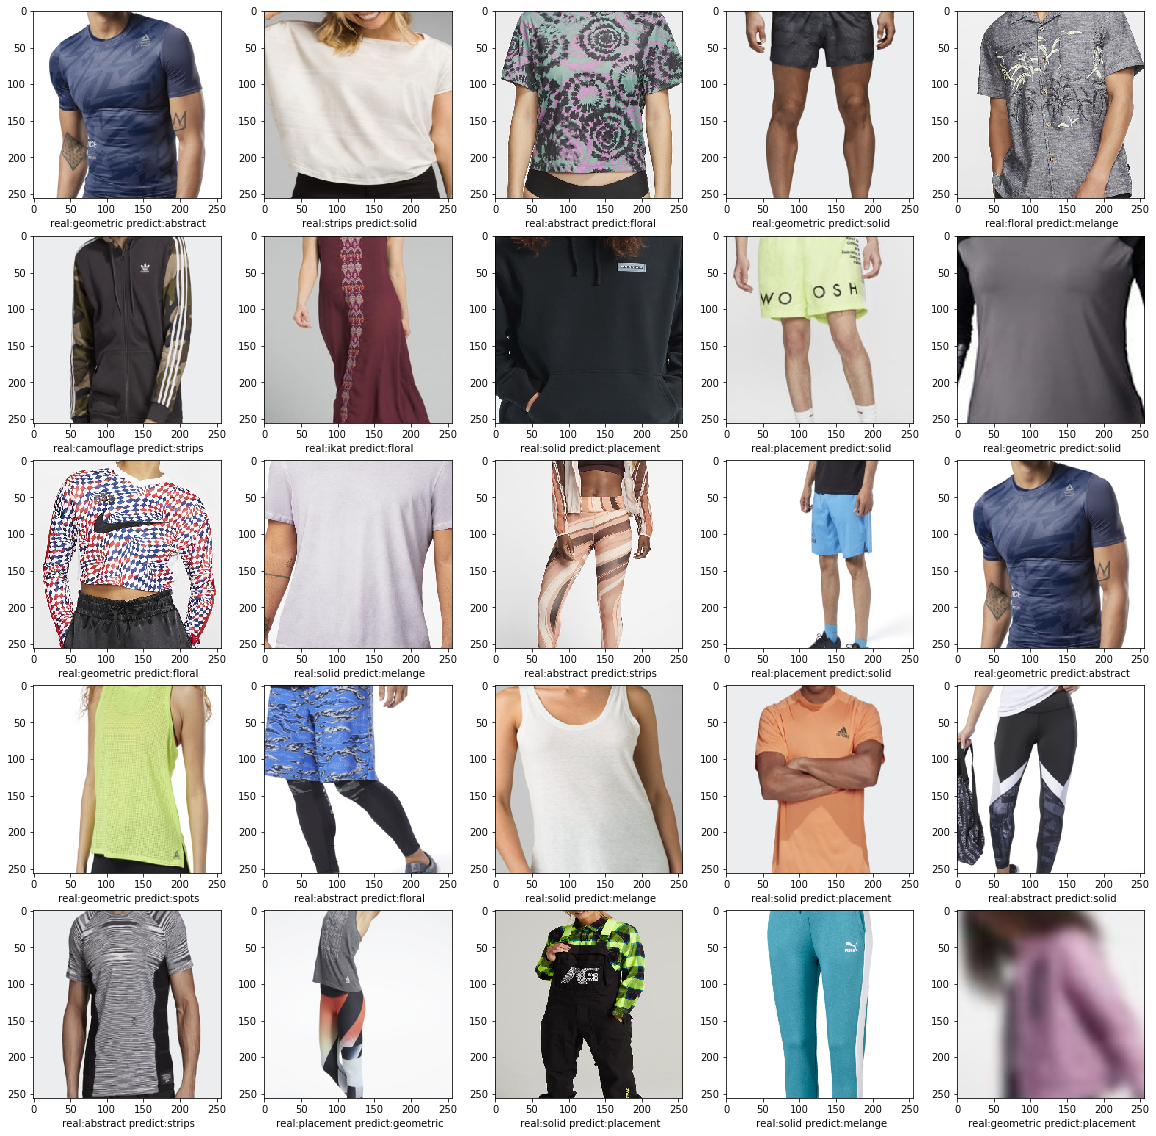

In [76]:
wrong_index = []  # 這個只是 X_test 的順序而已不是真的ID
for index, (a, b) in enumerate(zip(y_test_, y_pred)):
    if a != b:
        wrong_index.append(index)
# print(len(wrong_index))
import random
random_wrong_indexes = random.choices(wrong_index, k=25)
    
plt.figure(figsize=(20,20))
for i, df_index in enumerate(random_wrong_indexes):   # 這個只是 X_test 的順序而已不是真的ID
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[df_index].permute(1, 2, 0))
#     plt.xlabel('Id:' + str(df_index) + ' real:' + str(index2label[y_test[df_index]]) + ' predict:' + str(index2label[y_pred[df_index]]))  # id 指示輸入順序而已
    plt.xlabel(' real:' + str(index2label[y_test[df_index]]) + ' predict:' + str(index2label[y_pred[df_index]])) 
plt.show()

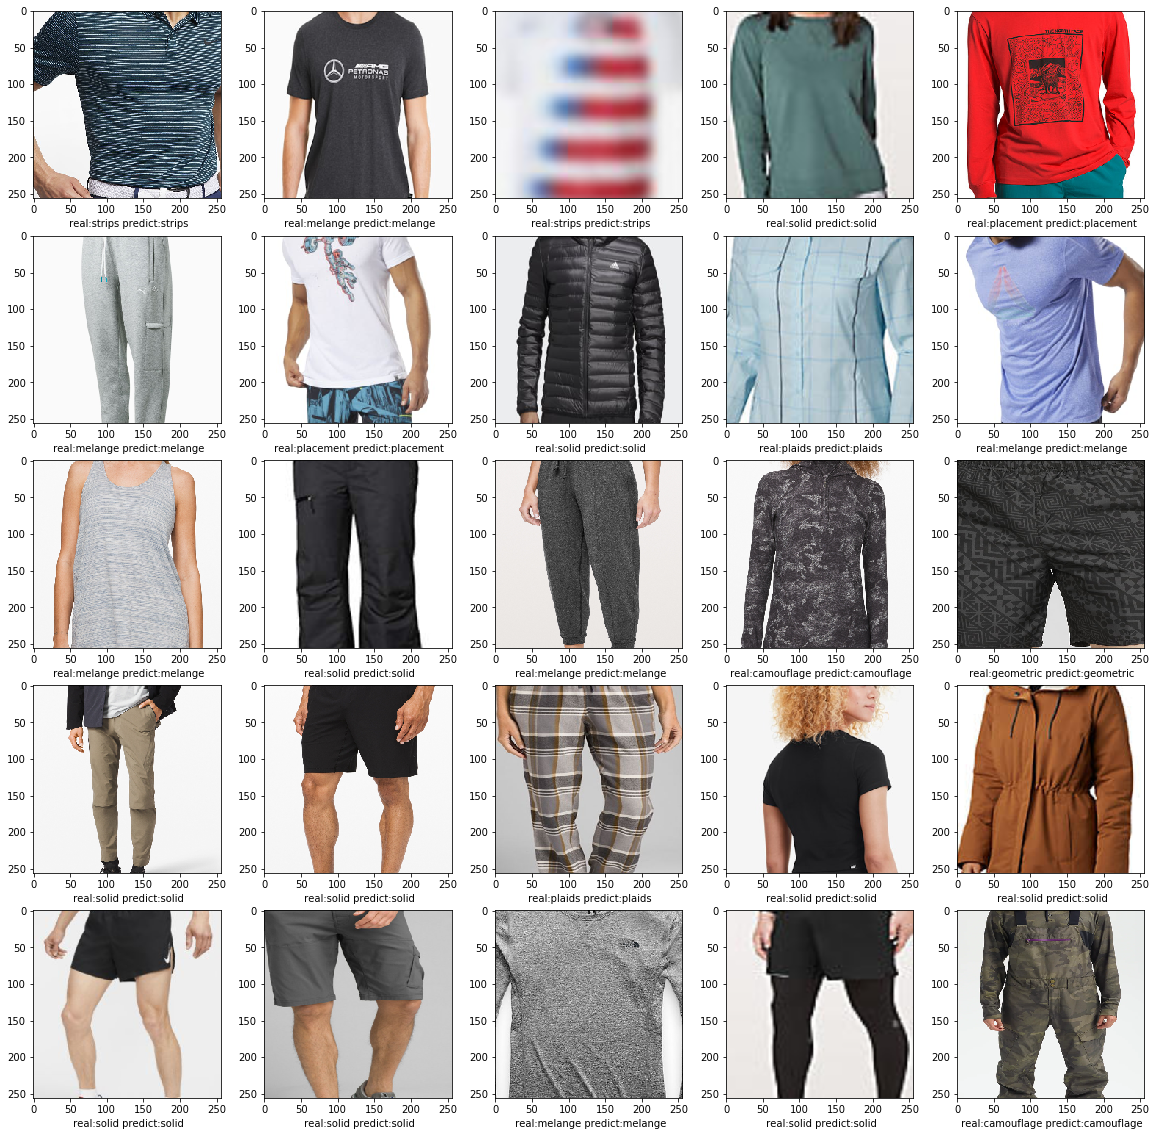

In [81]:
correct_index = []  # 這個只是 X_test 的順序而已不是真的ID
for index, (a, b) in enumerate(zip(y_test_, y_pred)):
    if a == b:
        correct_index.append(index)
# print(len(correct_index))
import random
random_correct_index = random.choices(correct_index, k=25)
    
    
plt.figure(figsize=(20,20))
for i, df_index in enumerate(random_correct_index):   # 這個只是 X_test 的順序而已不是真的ID
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[df_index].permute(1, 2, 0))
#     plt.xlabel('Id:' + str(df_index) + ' real:' + str(index2label[y_test[df_index]]) + ' predict:' + str(index2label[y_pred[df_index]]))  # id 指示輸入順序而已
    plt.xlabel(' real:' + str(index2label[y_test[df_index]]) + ' predict:' + str(index2label[y_pred[df_index]])) 
plt.show()

In [74]:
print(len(wrong_index))
print(len(correct_index))

504
1570


True

#### 附錄：這之後都只是一些小實驗，可以忽略

In [ ]:
# # 對照用，不要刪
# datagen = ImageDataGenerator(
#     featurewise_center = True, # 特徵均值為0，對應到Normalize?
#     zca_whitening=True,  # 沒有對應的
#     rotation_range=40, # (0, 40) 旋轉範圍，對應到 RandomRotation
#     width_shift_range=0.2, # 水平平移，最多總寬度*0.2，沒有對應套件
# #     height_shift_range=0.2,
#     brightness_range=[0.8,1.2], # 對應到ColorJitter
#     channel_shift_range=30, # 顏色，對應到ColorJitter
# #     shear_range=0.2,
#     zoom_range=0.2, # 圖片在長或寬放大縮小，參數大於0小於1時，執行的是放大操作，當參數大於1時，執行的是縮小操作。
#     horizontal_flip=True, # 對應到 RandomHorizontalFlip
#     fill_mode="constant",  # 填補空白的方式，沒有對應套件
#     cval=0.0  # fill_mode="constant"才要做
# )

In [ ]:
# # zca whitening 實作，但圖片並非M x N，不確定如何實作
# def zca_whitening_matrix(X):
#     """
#     Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
#     INPUT:  X: [M x N] matrix.
#         Rows: Variables
#         Columns: Observations
#     OUTPUT: ZCAMatrix: [M x M] matrix
#     """
#     # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
#     sigma = np.cov(X, rowvar=True) # [M x M]
#     # Singular Value Decomposition. X = U * np.diag(S) * V
#     U,S,V = np.linalg.svd(sigma)
#         # U: [M x M] eigenvectors of sigma.
#         # S: [M x 1] eigenvalues of sigma.
#         # V: [M x M] transpose of U
#     # Whitening constant: prevents division by zero
#     epsilon = 1e-5
#     # ZCA Whitening matrix: U * Lambda * U'
#     ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
#     return ZCAMatrix

# X = np.array([[0, 2, 2], [1, 1, 0], [2, 0, 1], [1, 3, 5], [10, 10, 10] ]) # Input: X [5 x 3] matrix
# ZCAMatrix = zca_whitening_matrix(X) # get ZCAMatrix
# ZCAMatrix # [5 x 5] matrix
# xZCAMatrix = np.dot(ZCAMatrix, X) # project X onto the ZCAMatrix
# xZCAMatrix # [5 x 3] matrix

In [ ]:
# pytorch 另一種data augmentation套件
# https://github.com/aleju/imgaug

# 參考資料
# https://www.itread01.com/content/1546227125.html#13transformsColorJitter_142
# https://zhuanlan.zhihu.com/p/30197320

In [ ]:
# transforms.ColorJitter(hue=0.5)()

In [ ]:
# a = X_train[0]
# plt.imshow(a)
# plt.show()

# b = Image.fromarray(a)
# b = transforms.ColorJitter(hue=0.1)(b)
# plt.imshow(b)
# plt.show()